In [1]:
## Load Packages and page set up
import pandas as pd
import numpy as np
import streamlit as st
from mplsoccer import Radar, PyPizza, FontManager
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore

st.set_page_config(layout="wide",
                   page_title = "Hertha Berlin Player Scouting Dashboard")

st.title("Hertha Berlin Player Scouting Dashboard")

2022-07-06 09:20:23.394 
  command:

    streamlit run C:\Apps-SU\anac\envs\SAL603\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [2]:
## Load Data -- All data is from fbref.com
######### Standard Stats #########

standard_stats = pd.DataFrame()
for league in ['Allsvenskan', 'Eliteserien', 'Superliga', 'Bundesliga']:
    for season in range(2021, 2022):
        sd_stats = pd.read_csv('H:/Desktop/Working Directory/Python/Sports Analytics/Sports Analytics for Python/Module 8 - Final Project/data/'+str(season)+'/'+str(league)+'/all_players_standard.csv',
                                encoding = "ISO-8859-1")
        sd_stats['League'], sd_stats['Season'] = league, season
        standard_stats = pd.concat([standard_stats, sd_stats])


standard_stats = standard_stats[['Player', 'Nation', 'Pos', 'Season', 'League', 'Squad', 'Age', '90s', 'Gls', 'Ast', 'G-PK', 'Gls.1', 'Ast.1', 'G+A']]

######### Shooting Stats #########

shooting_stats = pd.DataFrame()
for league in ['Allsvenskan', 'Eliteserien', 'Superliga', 'Bundesliga']:
    for season in range(2021, 2022):
        shot_stats = pd.read_csv('H:/Desktop/Working Directory/Python/Sports Analytics/Sports Analytics for Python/Module 8 - Final Project/data/'+str(season)+'/'+str(league)+'/all_players_shooting.csv',
                                encoding = "ISO-8859-1")
        shot_stats['League'], shot_stats['Season'] = league, season
        shooting_stats = pd.concat([shooting_stats, shot_stats])


shooting_stats = shooting_stats[['Player', 'Nation', 'Pos', 'Season', 'League', 'Squad', 'Age', '90s', 'Gls', 'Sh', 'SoT', 'SoT%', 'Sh/90', 'SoT/90', 'G/Sh', 'G/SoT']]

######### Misc/Defenstive Stats #########

misc_stats = pd.DataFrame()
for league in ['Allsvenskan', 'Eliteserien', 'Superliga', 'Bundesliga']:
    for season in range(2021, 2022):
        other_stats = pd.read_csv('H:/Desktop/Working Directory/Python/Sports Analytics/Sports Analytics for Python/Module 8 - Final Project/data/'+str(season)+'/'+str(league)+'/all_players_misc.csv',
                                encoding = "ISO-8859-1")
        other_stats['League'], other_stats['Season'] = league, season
        misc_stats = pd.concat([misc_stats, other_stats])


misc_stats = misc_stats[['Player', 'Nation', 'Pos', 'Season', 'League', 'Squad', 'Age', '90s', 'CrdY', 'CrdR', 'Fls', 'Crs', 'Int', 'TklW']]


In [3]:
########## One Dataframe ##########

soccer_stats = standard_stats.merge(shooting_stats, how = 'left', on = ['Player', 'Nation', 'Pos', 'Season', 'League', 'Squad', 'Age', '90s', 'Gls'])
soccer_stats = soccer_stats.merge(misc_stats, how = 'left', on = ['Player', 'Nation', 'Pos', 'Season', 'League', 'Squad', 'Age', '90s',])

#### Do Some Data Cleaning ####

soccer_stats['Minutes'] = soccer_stats['90s'] * 90 ## Create Minutes
soccer_stats = soccer_stats[soccer_stats.Pos != "GK"] ## Remove Goalkeepers

## Create Name Variable
soccer_stats_id = soccer_stats.Player.str.split("\\", expand = True)
soccer_stats['Player'] = soccer_stats_id[0]
soccer_stats['PlayerID'] = soccer_stats_id[1]


soccer_stats = soccer_stats[['Player', 'Nation', 'Pos', 'League', 'Squad', 'Age', 'Minutes', 'Gls', 'Ast', 'Sh', 'SoT', 'SoT%', 'G/Sh', 'G/SoT', 'Int', 'TklW', 'Fls', 'Crs', 'CrdY', 'CrdR']]

#### Recode Some Values ####
soccer_stats['Pos'] = soccer_stats['Pos'].replace(['DFFW'], 'DF')
soccer_stats['Pos'] = soccer_stats['Pos'].replace(['FWDF'], 'MF')
soccer_stats['Pos'] = soccer_stats['Pos'].replace(['MFDF'], 'MF')
soccer_stats['Pos'] = soccer_stats['Pos'].replace(['FWMF'], 'FW')

In [4]:
## Create streamlit filters
leagues = list(soccer_stats['League'].drop_duplicates())
positions = list(soccer_stats['Pos'].drop_duplicates())
age = list(soccer_stats['Age'].drop_duplicates())
minutes = list(soccer_stats['Minutes'].drop_duplicates())

In [5]:
## Create Filter styles

league_select = st.sidebar.multiselect(
    'Select Leagues:', leagues, default = leagues)

# position_select = st.sidebar.multiselect(
#     'Select Position:', positions, default = positions)

position_select = st.sidebar.selectbox(
    'Select Position:', positions)

player_age = st.sidebar.slider(
    'Age:', min_value = 15, max_value = 40, step = 1, value = (15, 40))

minutes_played = st.sidebar.slider(
    'Minutes Played:', min_value = 0, max_value = 3000, step = 50, value = (0, 3000))

In [6]:
## Add data to filters

soccer_stats = soccer_stats[soccer_stats['League'].isin(league_select)]
soccer_stats = soccer_stats[soccer_stats['Pos'] == position_select]
soccer_stats = soccer_stats[soccer_stats['Age'].between(*player_age)]
soccer_stats = soccer_stats[soccer_stats['Minutes'].between(*minutes_played)]

In [7]:
## Streamlit List of Available Players

soccer_stats = soccer_stats.sort_values('Pos', ascending = False).reset_index(drop = True)

st.markdown('# Available Players')
st.dataframe(soccer_stats[soccer_stats['League'] != 'Bundesliga'], width = 10000, height = 500)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [8]:
############# Player Selection ####

hertha_berlin = soccer_stats[soccer_stats['Squad'] == "Hertha BSC"]
hertha_players = list(hertha_berlin['Player'].drop_duplicates())
hertha_players.sort()

player_to_replace = st.sidebar.selectbox(
    'Player to Replace:', hertha_players)


hertha_berlin = hertha_berlin[hertha_berlin['Player'] == player_to_replace]

In [9]:
## Replacement Player List

available_players = soccer_stats[soccer_stats['League'] != "Bundesliga"]
replacement_players = list(available_players['Player'].drop_duplicates())
replacement_players.sort()

replacement = st.sidebar.selectbox(
    'Replacement Player:', replacement_players)

available_players = available_players[available_players['Player'] == replacement]

In [10]:
#### Set up Comparison 

player1 = hertha_berlin
player2 = available_players

comparison = pd.concat([player1, player2])

comparison_data = soccer_stats[soccer_stats['Pos'].isin(comparison['Pos'])]
comparison_data = comparison_data[['Gls', 'Ast', 'Sh', 'SoT', 'SoT%', 'G/Sh', 'G/SoT', 'Int', 'TklW', 'Fls', 'Crs']]

player1_values = player1[['Gls', 'Ast', 'Sh', 'SoT', 'SoT%', 'G/Sh', 'G/SoT', 'Int', 'TklW', 'Fls', 'Crs']].values.tolist()
player1_values = [x for xs in player1_values for x in xs]

player2_values = player2[['Gls', 'Ast', 'Sh', 'SoT', 'SoT%', 'G/Sh', 'G/SoT', 'Int', 'TklW', 'Fls', 'Crs']].values.tolist()
player2_values = [x for xs in player2_values for x in xs]

In [11]:
#### Radar Metrics ####

params = ['Gls', 'Ast', 'Sh', 'SoT', 'SoT%', 'G/Sh', 'G/SoT', 'Int', 'TklW', 'Fls', 'Crs']

high = list(comparison_data.quantile(.95))
low = list(comparison_data.quantile(.05))

In [12]:
##### Import Fonts ######

URL1 = ('https://github.com/googlefonts/SourceSerifProGFVersion/blob/main/'
        'fonts/SourceSerifPro-Regular.ttf?raw=true')
serif_regular = FontManager(URL1)
URL2 = ('https://github.com/googlefonts/SourceSerifProGFVersion/blob/main/'
        'fonts/SourceSerifPro-ExtraLight.ttf?raw=true')
serif_extra_light = FontManager(URL2)
URL3 = ('https://github.com/google/fonts/blob/main/ofl/rubikmonoone/'
        'RubikMonoOne-Regular.ttf?raw=true')
rubik_regular = FontManager(URL3)
URL4 = 'https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Thin.ttf?raw=true'
robotto_thin = FontManager(URL4)
URL5 = 'https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Regular.ttf?raw=true'
robotto_regular = FontManager(URL5)
URL6 = 'https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Bold.ttf?raw=true'
robotto_bold = FontManager(URL6)

In [13]:
#### Percentile of Statistics for replacement player

stat_percentile = []
for stat in range(0, 11):
    holder = round(percentileofscore(comparison_data.iloc[:,stat], player2_values[stat]))
    stat_percentile.append(holder)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

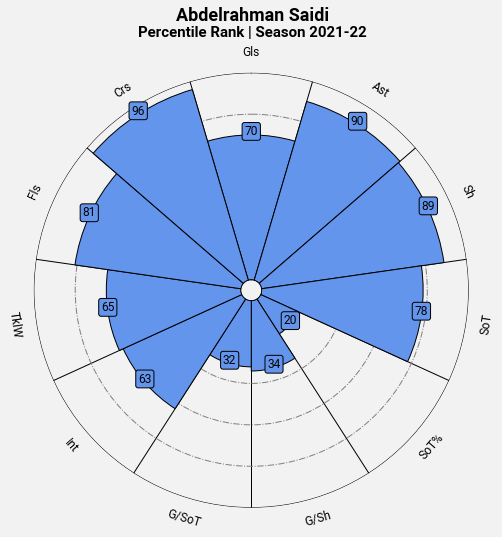

In [14]:
###### Percentile Chart ####
baker = PyPizza(
    params=params,                  # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)

fig, ax = baker.make_pizza(
    stat_percentile,              # list of values
    figsize=(8, 8),      # adjust figsize according to your need
    param_location=110,  # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=robotto_regular.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=robotto_regular.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

# add title
fig.text(
    0.515, 0.97, str(replacement), size=18,
    ha="center", fontproperties=robotto_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Percentile Rank | Season 2021-22",
    size=15,
    ha="center", fontproperties=robotto_bold.prop, color="#000000"
)

st.markdown("#")
st.markdown("#")
st.markdown("#")
st.markdown("#")
st.markdown("#")

st.pyplot(fig)

In [15]:
########## Build Radar ############

radar = Radar(params, low, high,
              # whether to round any of the labels to integers instead of decimal places
              round_int=[False]*11,
              num_rings=4,  # the number of concentric circles (excluding center circle)
              # if the ring_width is more than the center_circle_radius then
              # the center circle radius will be wider than the width of the concentric circles
              ring_width=1, center_circle_radius=1)


def radar_mosaic(radar_height=0.915, title_height=0.06, figheight=14):
    """ Create a Radar chart flanked by a title and endnote axes.

    Parameters
    ----------
    radar_height: float, default 0.915
        The height of the radar axes in fractions of the figure height (default 91.5%).
    title_height: float, default 0.06
        The height of the title axes in fractions of the figure height (default 6%).
    figheight: float, default 14
        The figure height in inches.

    Returns
    -------
    fig : matplotlib.figure.Figure
    axs : dict[label, Axes]
    """
    if title_height + radar_height > 1:
        error_msg = 'Reduce one of the radar_height or title_height so the total is ≤ 1.'
        raise ValueError(error_msg)
    endnote_height = 1 - title_height - radar_height
    figwidth = figheight * radar_height
    figure, axes = plt.subplot_mosaic([['title'], ['radar'], ['endnote']],
                                      gridspec_kw={'height_ratios': [title_height, radar_height,
                                                                     endnote_height],
                                                   # the grid takes up the whole of the figure 0-1
                                                   'bottom': 0, 'left': 0, 'top': 1,
                                                   'right': 1, 'hspace': 0},
                                      figsize=(figwidth, figheight))
    axes['title'].axis('off')
    axes['endnote'].axis('off')
    return figure, axes

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

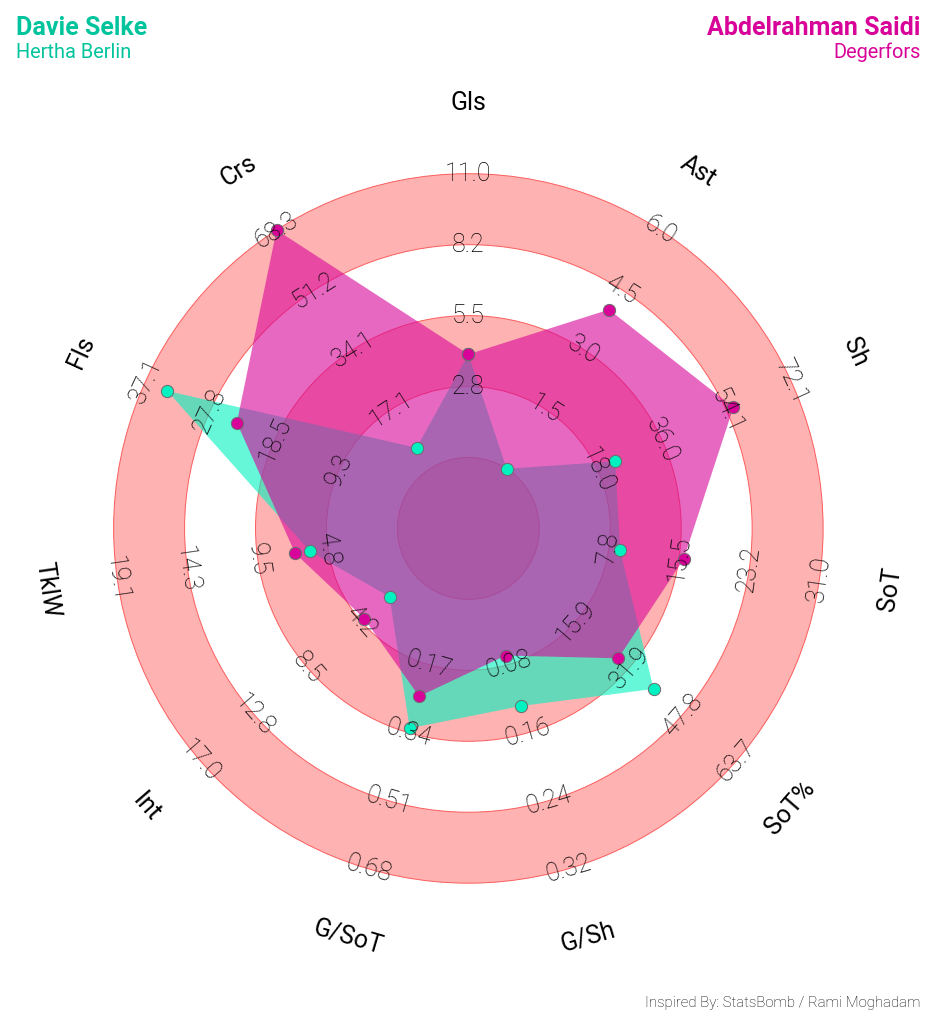

In [16]:
# creating the figure using the function defined above:
fig, axs = radar_mosaic(radar_height=0.915, title_height=0.06, figheight=14)

# plot radar
radar.setup_axis(ax=axs['radar'])  # format axis as a radar
rings_inner = radar.draw_circles(ax=axs['radar'], facecolor='#ffb2b2', edgecolor='#fc5f5f')
radar_output = radar.draw_radar_compare(player1_values, player2_values, ax=axs['radar'],
                                        kwargs_radar={'facecolor': '#00f2c1', 'alpha': 0.6},
                                        kwargs_compare={'facecolor': '#d80499', 'alpha': 0.6})
radar_poly, radar_poly2, vertices1, vertices2 = radar_output
range_labels = radar.draw_range_labels(ax=axs['radar'], fontsize=25,
                                       fontproperties=robotto_thin.prop)
param_labels = radar.draw_param_labels(ax=axs['radar'], fontsize=25,
                                       fontproperties=robotto_regular.prop)
axs['radar'].scatter(vertices1[:, 0], vertices1[:, 1],
                     c='#00f2c1', edgecolors='#6d6c6d', marker='o', s=150, zorder=2)
axs['radar'].scatter(vertices2[:, 0], vertices2[:, 1],
                     c='#d80499', edgecolors='#6d6c6d', marker='o', s=150, zorder=2)

# adding the endnote and title text (these axes range from 0-1, i.e. 0, 0 is the bottom left)
# Note we are slightly offsetting the text from the edges by 0.01 (1%, e.g. 0.99)
endnote_text = axs['endnote'].text(0.99, 0.5, 'Inspired By: StatsBomb / Rami Moghadam', fontsize=15,
                                   fontproperties=robotto_thin.prop, ha='right', va='center')
title1_text = axs['title'].text(0.01, 0.65, str(player_to_replace), fontsize=25, color='#01c49d',
                                fontproperties=robotto_bold.prop, ha='left', va='center')
title2_text = axs['title'].text(0.01, 0.25, 'Hertha Berlin', fontsize=20,
                                fontproperties=robotto_regular.prop,
                                ha='left', va='center', color='#01c49d')
title3_text = axs['title'].text(0.99, 0.65, str(replacement), fontsize=25,
                                fontproperties=robotto_bold.prop,
                                ha='right', va='center', color='#d80499')
title4_text = axs['title'].text(0.99, 0.25, player2['Squad'].to_string(index = False), fontsize=20,
                                fontproperties=robotto_regular.prop,
                                ha='right', va='center', color='#d80499')

st.markdown("#")
st.markdown("#")
st.markdown("#")
st.markdown("#")
st.markdown("#")
st.markdown("#")
st.markdown("#")
st.markdown('# Compare Selected Players')

st.pyplot(fig)

In [19]:
!jupyter nbconvert   --to script HerthaBerlinPlayerScoutingDashboard.ipynb
!awk '!/ipython/' HerthaBerlinPlayerScoutingDashboard.py >  temp.py && mv temp.py app.py && rm HerthaBerlinPlayerScoutingDashboard.py
!streamlit run HerthaBerlinPlayerScoutingDashboard.py

[NbConvertApp] Converting notebook HerthaBerlinPlayerScoutingDashboard.ipynb to script
[NbConvertApp] Writing 14818 bytes to HerthaBerlinPlayerScoutingDashboard.py
'awk' is not recognized as an internal or external command,
operable program or batch file.


^C
